In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open("names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [6]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [9]:
block_size = 3

def build_dataset(words):
    X, Y = [], []
    for w in words:

        # print(w)
        context = [0] * block_size
        for ch in w+'.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), "--->", itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])


In [67]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5)
b1 = torch.randn((n_hidden),                      generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn((vocab_size),                    generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1,n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]

print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12297


In [68]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    # forward pass
    emb = C[Xb] # (32, 3, 2)
    embcat = emb.view(emb.shape[0], -1)
    hpreact = emb.view(-1, 30) @ W1 + b1 # (32, 100)
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani / bnstdi) + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Yb)
    # print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if max_steps < 100000 else 0.05
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i % 10000 == 0:
        print(f'{i:7d}/ {max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
        
print(loss.item())

      0/  200000: 3.3089
  10000/  200000: 2.4635
  20000/  200000: 2.3472
  30000/  200000: 1.9449
  40000/  200000: 2.0394
  50000/  200000: 2.3409
  60000/  200000: 2.1907
  70000/  200000: 1.9576
  80000/  200000: 1.8769
  90000/  200000: 1.9834
 100000/  200000: 2.4136
 110000/  200000: 2.1890
 120000/  200000: 2.2936
 130000/  200000: 2.3483
 140000/  200000: 2.1019
 150000/  200000: 2.3452
 160000/  200000: 2.1474
 170000/  200000: 2.0612
 180000/  200000: 2.3837
 190000/  200000: 1.8308
2.3986494541168213


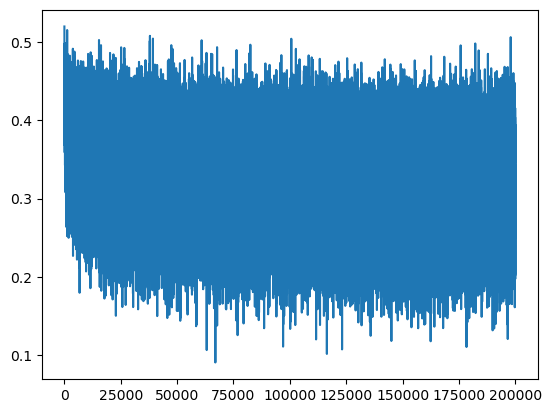

In [69]:
plt.plot(lossi)

In [65]:
# calibrate batch norm at the end of training

with torch.no_grad():
    # pass the training through
    emb = C[Xtr] 
    embcat = emb.view(emb.shape[0], -1)
    hpreact = emb.view(-1, 30) @ W1 + b1
    # measure themean/std over the training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)


In [70]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    
    emb = C[x] # (32, 3, 2)
    embcat = emb.view(emb.shape[0], -1)
    hpreact = emb.view(-1, 30) @ W1 + b1 # (32, 100)
    hpreact = bngain * (hpreact - bnmean_running / bnstd_running) + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('test')

train 2.087327241897583
test 2.158031940460205


In [71]:
# sample from the model
g = torch.Generator().manual_seed(2147483647+10)

for _ in range(20):
    out = []
    context = [0] * block_size
    
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1) # (n_embd, n_hidden)
        logits = h @ W2 + b2 # (n_embd, vocab_size)
        probs = F.softmax(logits, dim=1)
        
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

chriz.
fatill.
vith.
mri.
jertlynn.
joslee.
zhutrfy.
dra.
chriqui.
jermari.
chrihvik.
leggydh.
mond.
juququzza.
lilla.
jambriw.
jero.
deartin.
jumudpirrat.
eddy.
